<a href="https://colab.research.google.com/github/mohansameer1983/ComputerVisionProjects/blob/main/Trash_Multilabel_Classification_CV_Neptune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment only for first run
!pip install neptune-client neptune-tensorflow-keras tensorflow

     |████████████████████████████████| 315 kB 8.2 MB/s 
     |████████████████████████████████| 829 kB 45.5 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 181 kB 62.7 MB/s 
     |████████████████████████████████| 132 kB 46.7 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 8.6 MB 36.1 MB/s 
     |████████████████████████████████| 138 kB 54.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 127 kB 47.0 MB/s 
     |████████████████████████████████| 462 kB 52.4 MB/s 
     |████████████████████████████████| 130 kB 52.2 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.1-py2.py3-none-any.whl size=564805 sha256=e8ee34b361cd4ed79e91da6c03c848879d1c67ebefea136de0ed6db5767d71d7
  Stored in directory: /roo

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

import cv2
from google.colab.patches import cv2_imshow      # To show images using cv2 module
from pycocotools.coco import COCO

import pathlib
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Flatten

from keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is available


In [ ]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
run = neptune.init(
    project="mohansameer/Trash-Classification-Deep-Learning",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZjI5MDY4Yi0zMWVlLTQ3MmMtYjE4NS1iNDRjNGM0OTg4ZDkifQ==",
) 

https://app.neptune.ai/mohansameer/Trash-Classification-Deep-Learning/e/TRAS-20
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Model Selection

In [ ]:
  # Select base model  for transfer learning
  model_name = "mobilenet_v2_140_224" # @param [ 'efficientnet_v2_50', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152',  'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

  model_handle_map = {
    "efficientnet_v2_50": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",   
    "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
    "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
    "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
    "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
    "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5",
    "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
    "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
    "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
    "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
    "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
    "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
    "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
    "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
    "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
  }

  PIXELS = 224#@param {type:"integer"}
  BATCH_SIZE = 16#@param {type:"integer"}

  model_handle = model_handle_map.get(model_name)

  print(f"Selected model: {model_name} : {model_handle}")

  IMAGE_SIZE = (PIXELS, PIXELS)
  print(f"Input size {IMAGE_SIZE}")


Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Input size (224, 224)


In [ ]:
#Log to NeptuneAI
run["model/transferlearning/model_name"] = model_name
#run["model/transferlearning/model_url"] = model_handle
run["model/transferlearning/model_batch_size"] = BATCH_SIZE
run["model/parameters/image_size"] = IMAGE_SIZE

# Data Preparation

In [ ]:
def load_data(save_dir="./"):
  data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/data/trash') 

  datagen_kwargs = dict(rescale=1./255, validation_split=0.2,
                        featurewise_center=True)


  dataflow_kwargs = dict(target_size=(PIXELS, PIXELS), 
                        batch_size=BATCH_SIZE,
                        class_mode="categorical",
                        interpolation="nearest")

  valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      **datagen_kwargs)
  # specify imagenet mean values for centering
  valid_datagen.mean = [123.68, 116.779, 103.939]

  valid_generator = valid_datagen.flow_from_directory(
      data_dir, subset="validation", 
      shuffle=False, **dataflow_kwargs)
  
  train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            **datagen_kwargs)
  # specify imagenet mean values for centering
  train_datagen.mean = [123.68, 116.779, 103.939]

  train_generator = train_datagen.flow_from_directory(
          data_dir, subset="training",
          **dataflow_kwargs)
  return valid_generator, train_generator

VAL_generator, TRAIN_generator = load_data()

Found 601 images belonging to 60 classes.
Found 2522 images belonging to 60 classes.


In [ ]:
class_names = TRAIN_generator.class_indices.items()
print(class_names)

dict_items([('Aerosol', 0), ('Aluminium blister pack', 1), ('Aluminium foil', 2), ('Battery', 3), ('Broken glass', 4), ('Carded blister pack', 5), ('Cigarette', 6), ('Clear plastic bottle', 7), ('Corrugated carton', 8), ('Crisp packet', 9), ('Disposable food container', 10), ('Disposable plastic cup', 11), ('Drink can', 12), ('Drink carton', 13), ('Egg carton', 14), ('Foam cup', 15), ('Foam food container', 16), ('Food Can', 17), ('Food waste', 18), ('Garbage bag', 19), ('Glass bottle', 20), ('Glass cup', 21), ('Glass jar', 22), ('Magazine paper', 23), ('Meal carton', 24), ('Metal bottle cap', 25), ('Metal lid', 26), ('Normal paper', 27), ('Other carton', 28), ('Other plastic', 29), ('Other plastic bottle', 30), ('Other plastic container', 31), ('Other plastic cup', 32), ('Other plastic wrapper', 33), ('Paper bag', 34), ('Paper cup', 35), ('Paper straw', 36), ('Pizza box', 37), ('Plastic bottle cap', 38), ('Plastic film', 39), ('Plastic glooves', 40), ('Plastic lid', 41), ('Plastic str

# Modelling

## Build and Train Model


In [ ]:
def build_model(trainable=False, params={}):
   print("Building model with", model_handle)
   # Download the pretrained model and save it as a Keras layer
   '''feature_extractor_layer = hub.KerasLayer(model_handle,
                                           trainable=trainable, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SIZE+(3,)) # define the input image shape
   model = keras.Sequential([
        feature_extractor_layer,
        keras.layers.Dense(params['dense_units_1'],activation=params['dense_layer_activation_1']),
        keras.layers.Dropout(params['dropout']),
        keras.layers.Dense(TRAIN_generator.num_classes, activation=params['final_layer_activation'],
                              kernel_regularizer=tf.keras.regularizers.l2(params['regularizer_rate']))])
   model.build((None,)+IMAGE_SIZE+(3,))'''                                        
   
   base_model=keras.applications.MobileNetV2(weights='imagenet',include_top=False,
                     input_shape=IMAGE_SIZE+(3,)) #imports the mobilenet model and discards the last 1000 neuron layer.

   base_model.trainable = False                                      

   inputs = keras.Input(shape=IMAGE_SIZE+(3,))
   x = base_model(inputs, training=False)
   x = keras.layers.GlobalAveragePooling2D()(x)
   x=Dense(params['dense_units_1'],activation=params['dense_layer_activation_1'])(x)
   #x=Dropout(params['dropout_1'])(x)
   #x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
   #x=Dropout(params['dropout_2'])(x)
   outputs = keras.layers.Dense(TRAIN_generator.num_classes, activation=params['final_layer_activation'])(x)
   model = keras.Model(inputs, outputs)

   model.summary()
   return model

params = {
    "dense_units_1": 128,
    "dense_layer_activation_1": "relu",
    "dropout_1": 0.1,    
    "dense_units_2": 512,
    "dense_layer_activation_2": "relu",
    "dropout_2": 0.1,
    "final_layer_activation": "sigmoid",
    "learning_rate": 1e-2,
    "n_epochs": 20,    
    "regularizer_rate":0.005
}
run["model/parameters"] = params
model = build_model(params=params)

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4


AttributeError: ignored

In [ ]:
from keras import backend
 
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [ ]:
def compile_model(model):
  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=params['learning_rate']), 
  loss='binary_crossentropy',
  metrics=['accuracy'])
  return model

model = compile_model(model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Add Callbacks

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5', save_best_only = True, verbose = 0)

# Early Stopping Checkpoint
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

In [ ]:
def train_model(model, num_epochs):

    steps_per_epoch = TRAIN_generator.samples // TRAIN_generator.batch_size
    validation_steps = VAL_generator.samples // VAL_generator.batch_size

    history = model.fit(
      TRAIN_generator,
      epochs=num_epochs, steps_per_epoch=steps_per_epoch,
      validation_data = VAL_generator,
      validation_steps = validation_steps,
      callbacks=[NeptuneCallback(run=run), EarlyStoppingCallback]).history
    
    return model, history

model, history = train_model(model, num_epochs=params['n_epochs'])

Epoch 1/50
157/157 [==============================] - 1017s 6s/step - loss: 3.6689 - fbeta: 0.1933 - val_loss: 3.3507 - val_fbeta: 0.2023
Epoch 2/50
157/157 [==============================] - 393s 3s/step - loss: 3.3895 - fbeta: 0.2029 - val_loss: 3.2790 - val_fbeta: 0.2104
Epoch 3/50
157/157 [==============================] - 390s 2s/step - loss: 3.3197 - fbeta: 0.2066 - val_loss: 3.3124 - val_fbeta: 0.2012
Epoch 4/50
157/157 [==============================] - 440s 3s/step - loss: 3.2976 - fbeta: 0.2037 - val_loss: 3.3507 - val_fbeta: 0.2046
Epoch 5/50
157/157 [==============================] - 439s 3s/step - loss: 3.2387 - fbeta: 0.2068 - val_loss: 3.2987 - val_fbeta: 0.2045
Epoch 6/50
157/157 [==============================] - 439s 3s/step - loss: 3.2131 - fbeta: 0.2090 - val_loss: 3.2954 - val_fbeta: 0.2018
Epoch 7/50
157/157 [==============================] - 442s 3s/step - loss: 3.2408 - fbeta: 0.2078 - val_loss: 3.5006 - val_fbeta: 0.1909
Epoch 8/50
157/157 [====================

KeyError: ignored

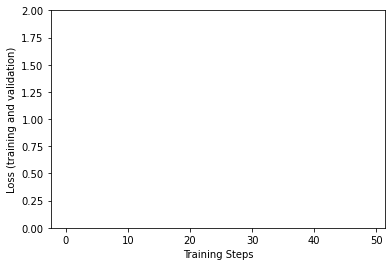

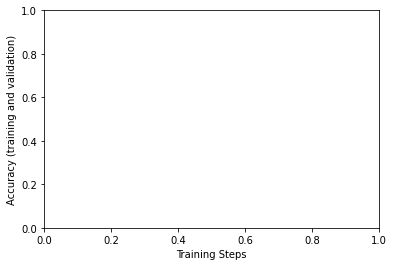

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [ ]:
# define filename
filename = '/content/drive/MyDrive/Colab Notebooks/data/trash/Aerosol/batch_1_000054.jpg'

img = tf.keras.preprocessing.image.load_img(
    filename, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.sigmoid(predictions[0])
print(score)
print(list(class_names))
print( "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(list(class_names)[np.argmax(score)], 100 * np.max(score)) )

In [ ]:
# Generate predictions
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

OSError: ignored

# Save Model

In [ ]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Models/saved_garbageclassification_model"
tf.saved_model.save(model, saved_model_path)

# Fine Tuning